In [217]:
import numpy as np
from astropy.io import ascii
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pystan as ps
import arviz as av
import seaborn as sns
import pickle
import astropy.units as u
import astropy.constants as const

%matplotlib inline

In [4]:
data = ascii.read('/Users/samberek/Courses/1501project/pythoncode/NGC1407_GC.cat')

In [5]:
data.remove_row(348)
data.remove_row(343)
data.remove_row(264)
data.remove_row(13) 

In [6]:
los_vel = data['RV'] - 1779

In [106]:
def dist_calc(angrad):
    angle = angrad*u.arcmin
    radangle = angle.to(u.rad)
    convert = np.tan(radangle/2)*2*(24.4*u.Mpc)
    
    return (convert.to(u.kpc)).value

radius_kpc = np.array([dist_calc(i) for i in data['RAD']])

Data needs to be in a dictionary to be passed to Stan

In [8]:
standata = {
    'N': len(data),

    'r_obs': radius_kpc,
    'rv_obs': los_vel,
    'rv_err': data['RV_err'],
}

In [290]:
with open('single_hernquist.stan', 'r') as f:
    stancode = f.read()
    
sm = ps.StanModel(model_code=stancode)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13aee4be7b7cacf69a396f31cdb526ce NOW.


Initial values

In [291]:
def initial_values():
    return {
        
        #there needs to be a better prior here
        #'rho0': 1e6,
        'logM': 13,
        'a': 5,
        
#         'x': np.full(standata['N'], 10),
#         'v_yz': np.full(standata['N'], 10),
        
        'x': np.random.uniform(10,40, size=standata['N']),
        'v_yz': np.random.uniform(0,100, size=standata['N']),
        

        #'xv': np.random.uniform(min(standata['rv_obs']), max(standata['rv_obs']), size=int(standata['N']))
    }

In [292]:
adapt = {
    'adapt_delta': 0.95,
    'max_treedepth': 12
}

In [293]:
fit = sm.sampling(data=standata,
                  init=initial_values,
                  n_jobs = 1,
                  iter=2000, 
                  #chains=1, #1 for diagnostics
                  control = adapt, 
                  verbose=True
                 )

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [294]:
print(fit.stansummary())

Inference for Stan model: anon_model_13aee4be7b7cacf69a396f31cdb526ce.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM        13.31    0.01   0.21  12.93  13.14   13.3  13.47  13.67    354    1.0
a            5.32     0.1   2.68   0.85   3.27   5.25   7.11   10.7    716    1.0
x_raw[1]     0.42    0.01   0.28   0.01   0.18   0.38   0.63   0.97    672    1.0
x_raw[2]     0.44    0.01   0.27   0.02   0.21   0.41   0.65   0.95    719   1.01
x_raw[3]     0.41  9.0e-3   0.27   0.02   0.18   0.38   0.62   0.94    881    1.0
x_raw[4]     0.41  9.1e-3   0.27   0.02   0.18   0.37   0.62   0.93    872   1.01
x_raw[5]     0.42  9.8e-3   0.27   0.02   0.19   0.39   0.63   0.95    773   1.01
x_raw[6]     0.41  8.6e-3   0.27   0.02   0.18   0.39   0.61   0.95    973    1.0
x_raw[7]     0.42  9.9e-3   0.27   0.02   0.19   0.39   0.64   0.95    75

In [295]:
params = ["logM", "a"]

In [296]:
print(fit.stansummary(pars=params))

Inference for Stan model: anon_model_13aee4be7b7cacf69a396f31cdb526ce.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM  13.31    0.01   0.21  12.93  13.14   13.3  13.47  13.67    354    1.0
a      5.32     0.1   2.68   0.85   3.27   5.25   7.11   10.7    716    1.0

Samples were drawn using NUTS at Fri Mar 19 10:39:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


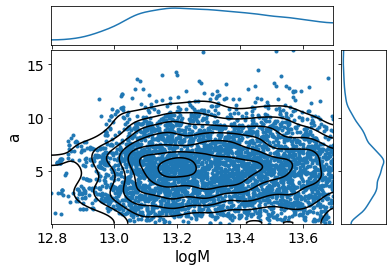

In [297]:
av.plot_pair(fit, var_names=params, kind=['kde', 'scatter'], marginals=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdfe511340>,
      dtype=object)

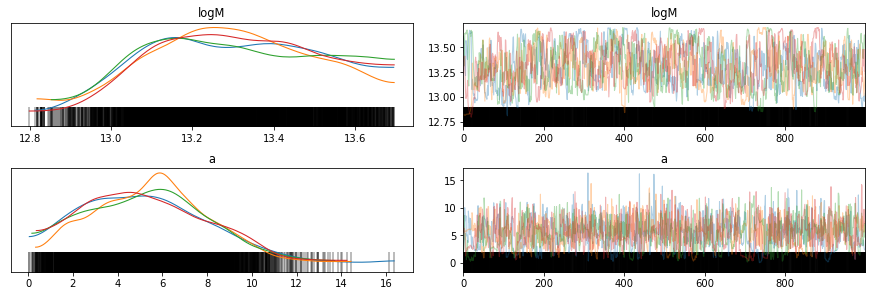

In [298]:
av.plot_trace(fit, var_names=params)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_traceplots_normalpositionprior_sdandmaxvalue.pdf')

/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (370), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe0e400eb0>,
      dtype=object)

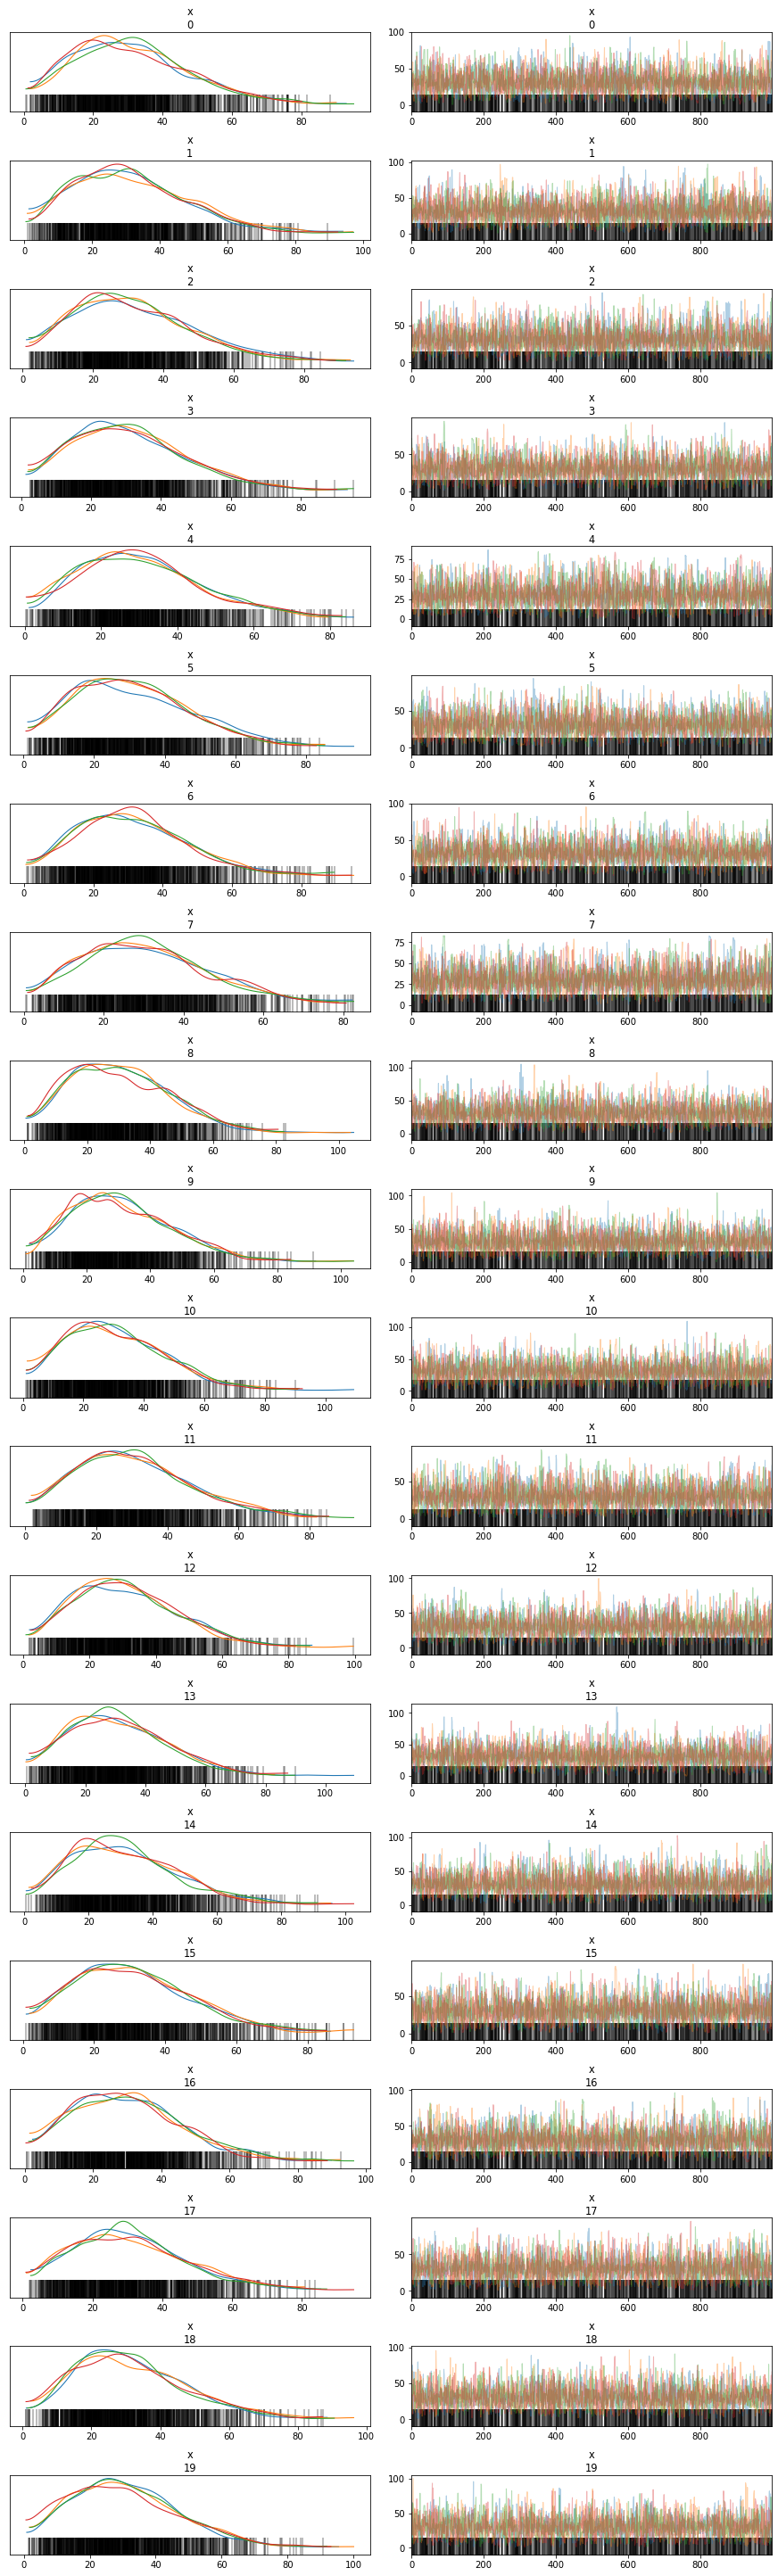

In [249]:
params2 = ["x"]

#av.plot_pair(fit, var_names=params2, kind=['kde', 'scatter'], marginals=True);
av.plot_trace(fit, var_names=params2)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_traceplots_xvalues_sdandmaxvalue.pdf')

/Users/samberek/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (370), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe74492670>,
      dtype=object)

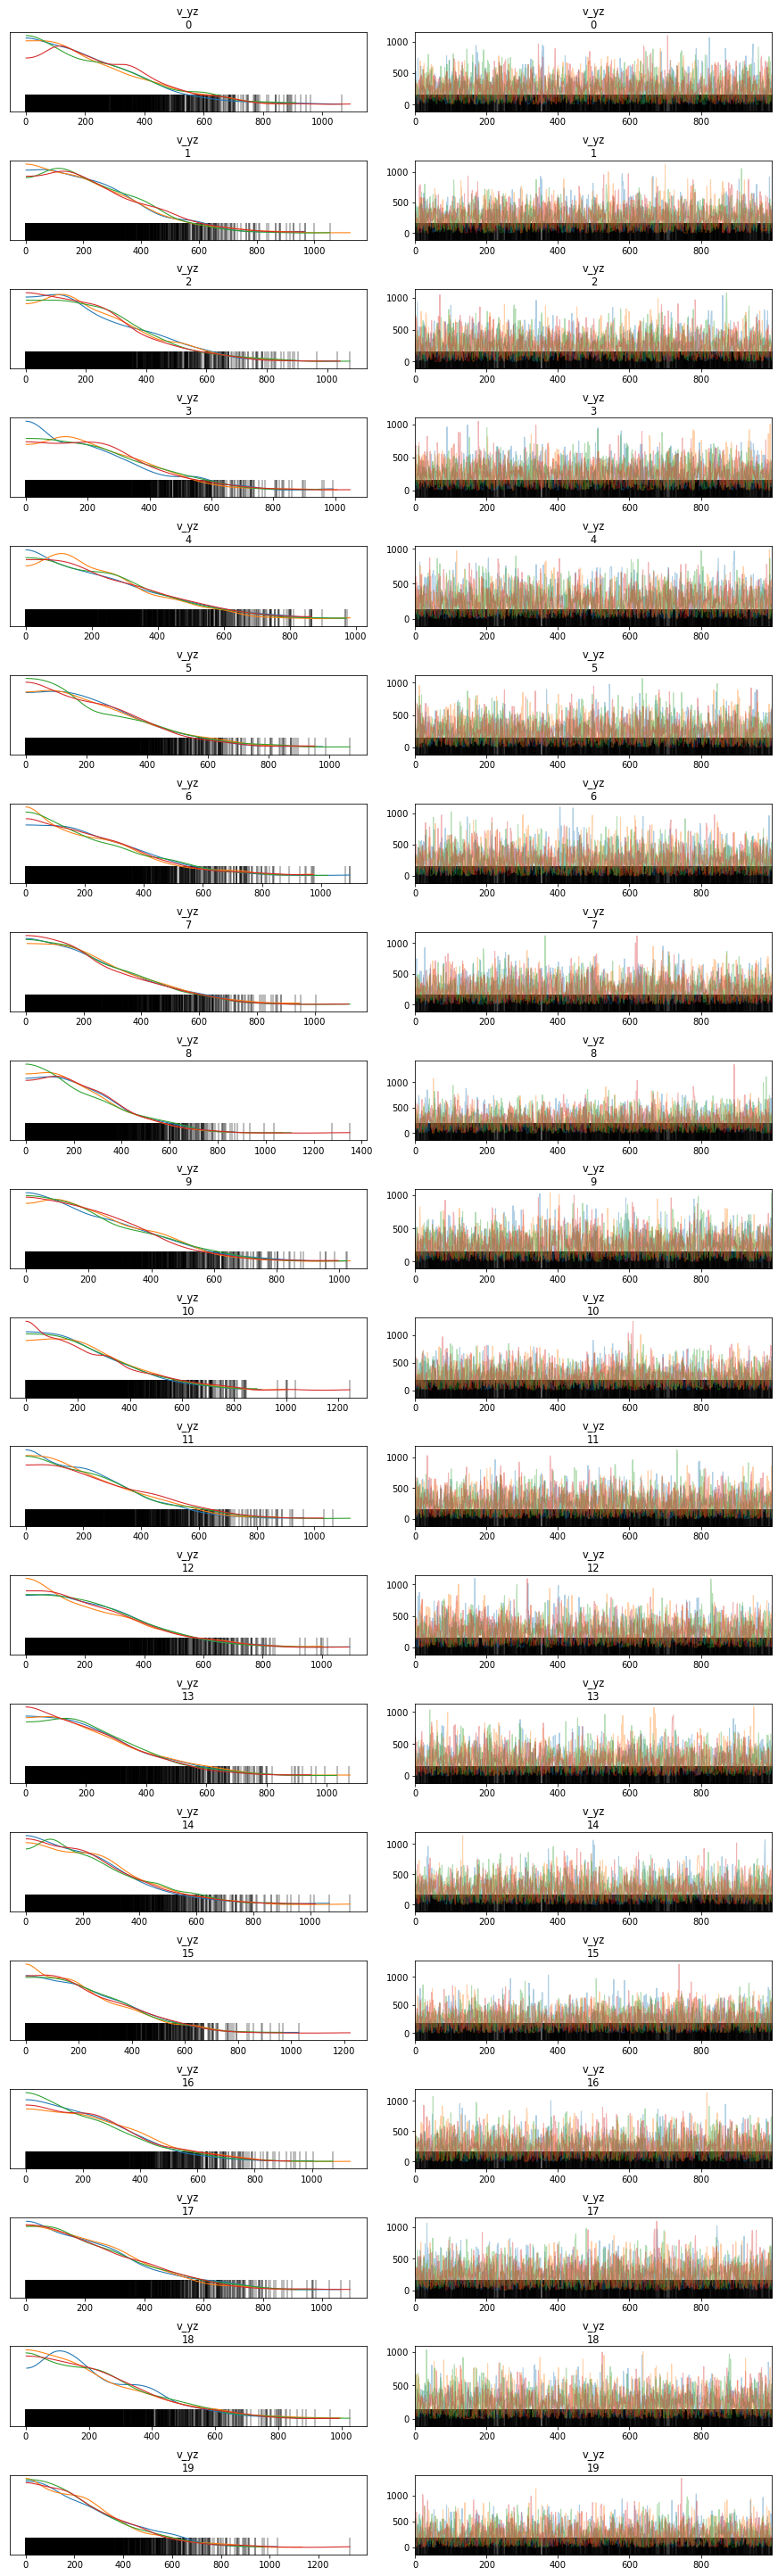

In [202]:
params3 = ["v_yz"]

#av.plot_pair(fit, var_names=params2, kind=['kde', 'scatter'], marginals=True);
av.plot_trace(fit, var_names=params3)

# Investigating Fits

In [299]:
la = fit.extract()

In [300]:
#distribution of x values
flat_x = (la['x']).flatten()
mean_x = [np.mean(la['x'][:,i]) for i in range(370)]
mean_xraw = [np.mean(la['x_raw'][:,i]) for i in range(370)]
mean_vel_yz = [np.mean(la['v_yz'][:,i]) for i in range(370)]

## Just looking at positions

Text(0.5, 0, 'predicted line-of-sight position')

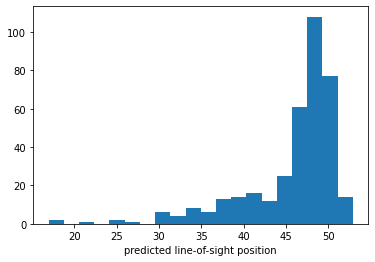

In [301]:
#predicted line-of sight positions
plt.hist(mean_x, bins=20)
plt.xlabel('predicted line-of-sight position')

(array([ 2.,  4.,  2.,  7.,  8., 20., 27., 38., 38., 50., 35., 38., 25.,
        24., 29., 11.,  3.,  4.,  3.,  2.]),
 array([0.3896799 , 0.39246992, 0.39525993, 0.39804995, 0.40083997,
        0.40362998, 0.40642   , 0.40921001, 0.41200003, 0.41479004,
        0.41758006, 0.42037007, 0.42316009, 0.4259501 , 0.42874012,
        0.43153013, 0.43432015, 0.43711017, 0.43990018, 0.4426902 ,
        0.44548021]),
 <a list of 20 Patch objects>)

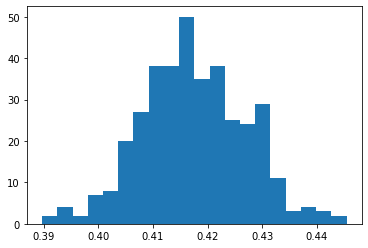

In [302]:
#standardized predicted line-of-sight positions
plt.hist(mean_xraw, bins=20)

Text(0.5, 0, 'radial position')

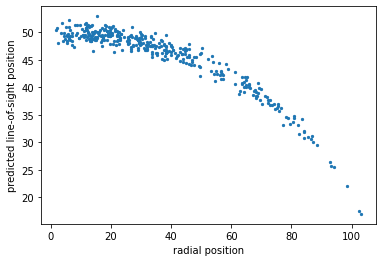

In [304]:
#scatterplots of positions 

plt.scatter(radius_kpc, mean_x, s=5)
plt.ylabel('predicted line-of-sight position')
plt.xlabel('radial position')

In [268]:
#transform RA and Dec into positions to plot
ra_sep = (55.049417*u.degree - data['RA']*u.degree).to(u.rad)
dec_sep = (-18.58011*u.degree - data['DEC']*u.degree).to(u.rad)

y_pos_ra = ((24.4*u.Mpc)*ra_sep).to(u.kpc*u.rad).value
z_pos_dec = ((24.4*u.Mpc)*dec_sep).to(u.kpc*u.rad).value

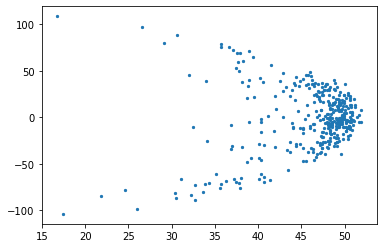

In [269]:
plt.scatter(mean_x, y_pos_ra, s=5)

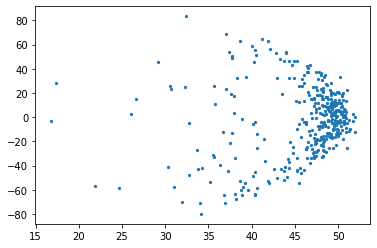

In [270]:
plt.scatter(mean_x, z_pos_dec, s=5)

<IPython.core.display.Javascript object>


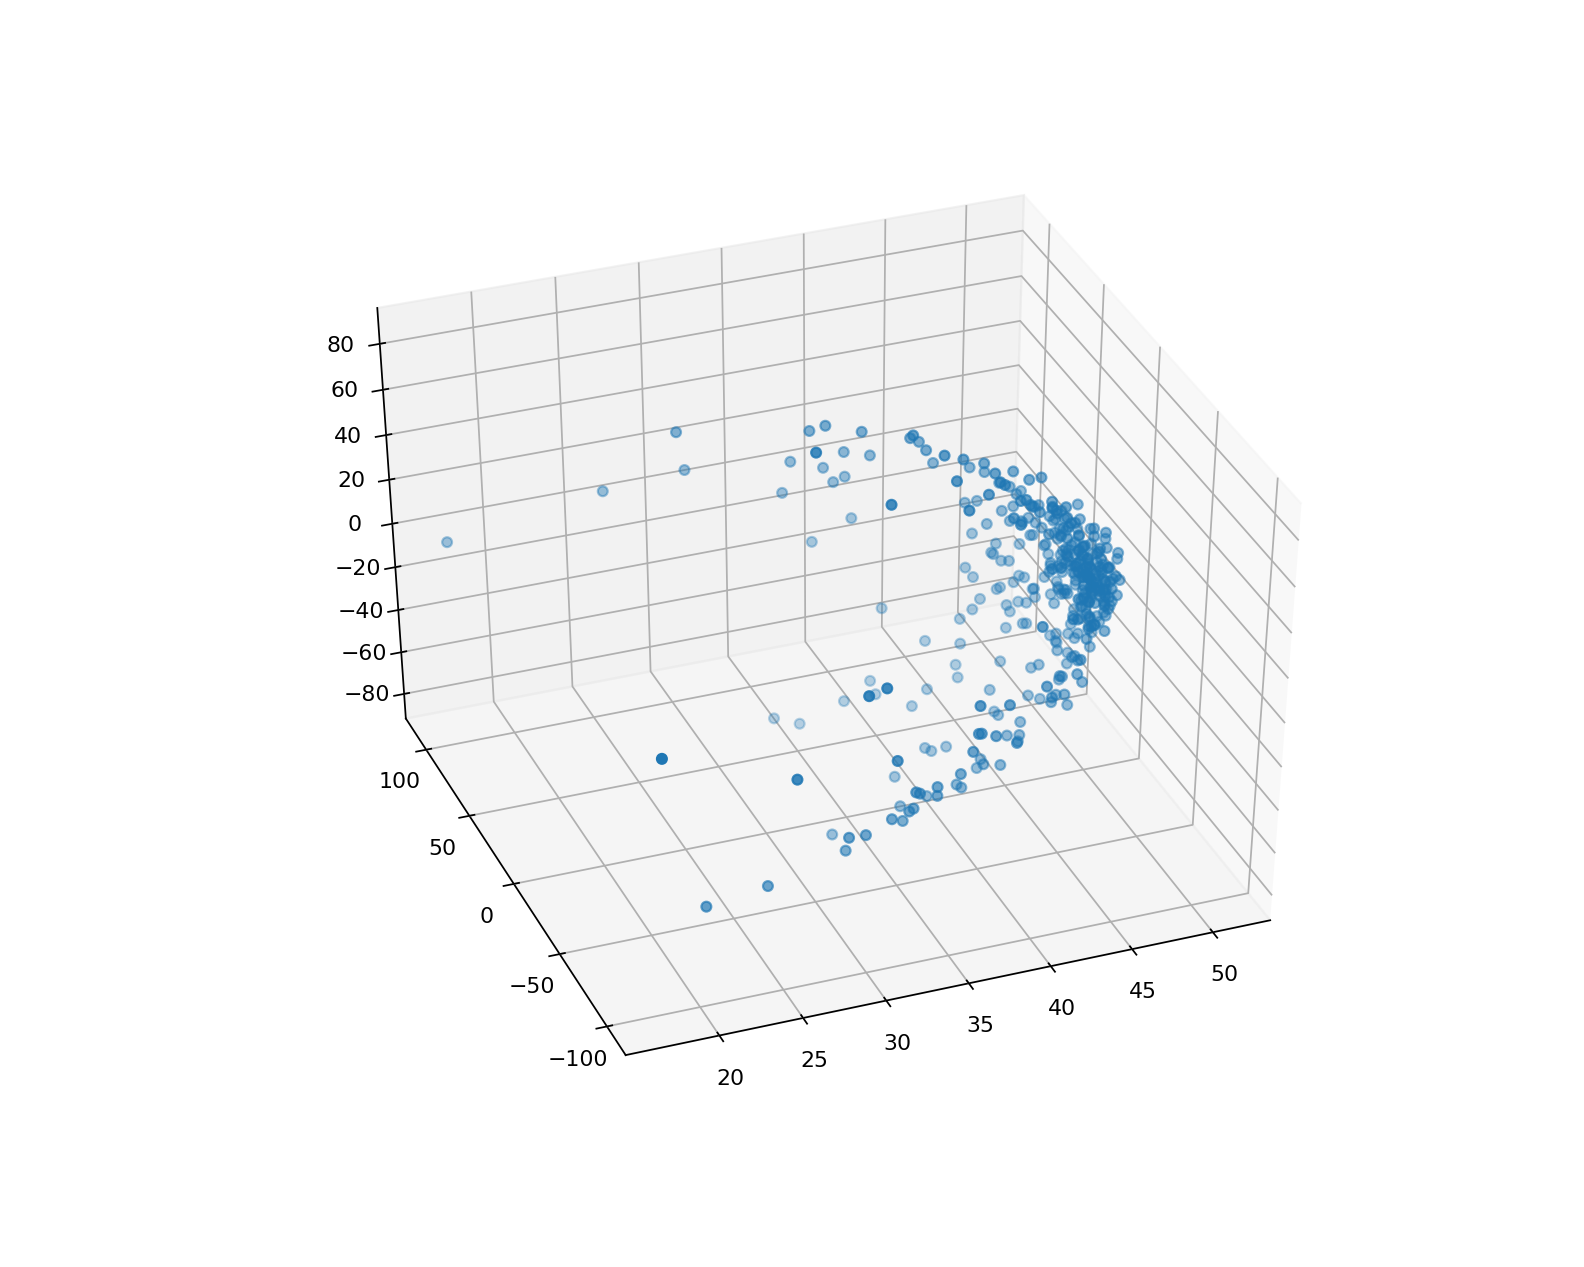

In [204]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(mean_x, y_pos_ra, z_pos_dec)

In [305]:
#just some reshaping

mean_x = np.array([mean_x])
mean_x = np.reshape(mean_x, newshape=370)

mean_yz = np.array([mean_vel_yz])
mean_yz = np.reshape(mean_yz, newshape=370)

In [306]:
three_d_pos = np.sqrt(mean_x**2 + radius_kpc**2)
three_d_speed = np.sqrt(los_vel**2 + mean_yz**2)

Text(0.5, 0, '3d radius from center')

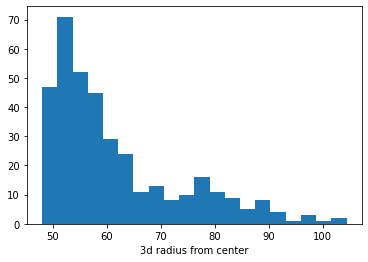

In [307]:
plt.hist(three_d_pos, bins=20)
plt.xlabel('3d radius from center')

## Velocities too now!

In [308]:
def esc_vel(pos, mass): 
    G = 4.3009173e-6
    return np.sqrt(2*G*mass/pos)

<ipython-input-308-0b3591b307ef>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(2*G*mass/pos)


(40.0, 120.0)

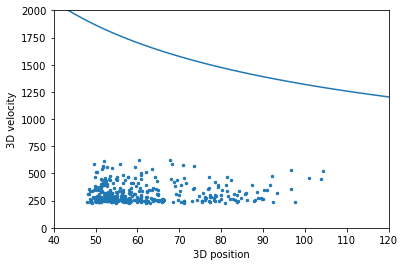

In [312]:
pos_array = np.linspace(0,120, 100)
logmass_est = np.mean(la['logM'])
mass_est = 10**logmass_est

plt.plot(pos_array, esc_vel(pos_array, mass_est))
plt.scatter(three_d_pos, three_d_speed, s=6)
plt.xlabel('3D position')
plt.ylabel('3D velocity')
plt.ylim(0,2000)
plt.xlim(40,120)

# Enclosed mass 

In [186]:
def mass_enclosed(r, samples, full=False):
    mass = 10**samples['logM']
    a = samples['a']
    masses = mass*((r/a)**2/((1+(r/a))**2))


#     if full: 
#         return masses
    
    return np.quantile(masses, [0.025, 0.125, 0.25, 0.5, 0.75, 0.875, 0.975]) # quantiles that we want to get

In [187]:
print("Enclosed mass: %.4g" %mass_enclosed(300,la)[3])

Enclosed mass: 1.543e+13


(array([-5.0e+12,  0.0e+00,  5.0e+12,  1.0e+13,  1.5e+13,  2.0e+13,
         2.5e+13,  3.0e+13]),
 <a list of 8 Text major ticklabel objects>)

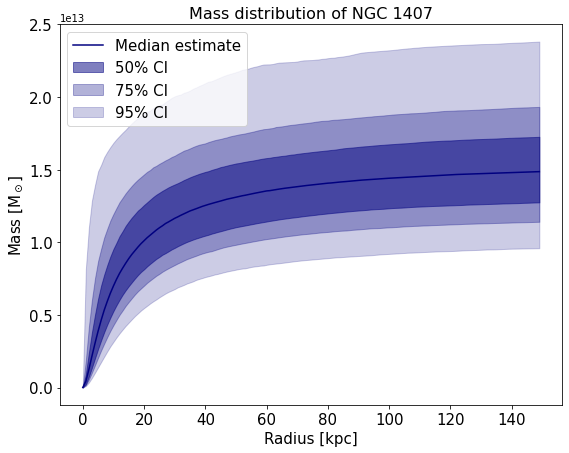

In [190]:
plt.figure(figsize=(9, 7))
radii = np.arange(150) # up to 250 kpc
masses = np.zeros((len(radii), 7))

for r in radii:
    masses[r] = mass_enclosed(r, la) # 251 x 7 array of various quantiles of masses at different radii
    
plt.plot(radii, masses[:, 3], c='navy', label='Median estimate')
plt.fill_between(radii, masses[:, 2], masses[:, 4], alpha=0.5, color='navy', label='50% CI')
plt.fill_between(radii, masses[:, 1], masses[:, 5], alpha=0.3, color='navy', label='75% CI')
plt.fill_between(radii, masses[:, 0], masses[:, 6], alpha=0.2, color='navy', label='95% CI')

plt.legend(loc='upper left', fontsize=15)
plt.title('Mass distribution of NGC 1407', fontsize=16)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel(r'Mass [M$_\odot$]', fontsize=15)
#plt.xlim(-1, 100)
#plt.yscale('log')
plt.xticks(size=15)
plt.yticks(size=15)
#plt.savefig('/Users/samberek/Courses/1501project/results/mass_dists/singlehernquist_log3.pdf')

In [ ]:
#I'll do M_200 by calculating the radius for which density is 200 times density of the universe

def calc_rvir(gamma, phi0, H=0.678e-3):
    return (gamma * phi0 / (100 * H**2)) ** (1 / 2 + gamma)

rvir = calc_rvir(
    np.median(la['p_gamma']), 
    np.median(la['p_phi0'])
) / 1000 # convert to kpc

plt.figure(figsize=(9, 7))

virial_mass = mass_at_radius(rvir, la, full=True)

sns.distplot(virial_mass) # density 
plt.axvline(np.median(virial_mass)) # draw a vertical line at the median mass
plt.annotate(rf"median: {np.median(virial_mass):.2f} $\times 10^{{12}}$ M$_\odot$", xy=(0.55, 0.7), xycoords='axes fraction', fontsize=15)

plt.title(rf'Distribution of M$_{{{200}}}$ = M(<{rvir:.0f} kpc)', fontsize=15)
plt.xlabel(r'Mass [$\times 10^{12}$ M$_\odot$]', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(size=15)
plt.yticks(size=15);